In [1]:
# ======================================================================
# 🌎 GLOBAL ROLLING FORECAST PIPELINE (Past Covariates, CFPR Hierarchy)
#   - Matches local notebook behavior:
#     * Predict on training slice per category (<= cutoff)
#     * Evaluate on next-year window
#     * Save in CFPR hierarchy with Covariates tag
# ======================================================================

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

# ----------------------------------------------------------------------
# 🧮 Load & Prepare Global Dataset
# ----------------------------------------------------------------------
def prepare_timeseries_dataset(csv_path, covariates=None):
    """
    Load CFPR dataset with covariates (treated as past regressors).
    """
    df = pd.read_csv(csv_path)
    print(f"✅ Loaded dataset with shape {df.shape}")

    # Detect timestamp column
    possible_date_cols = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
    timestamp_col = possible_date_cols[0] if possible_date_cols else "timestamp"
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Identify covariates and targets
    if covariates is None:
        covariates = ["Geopolitical_clean", "Climate", "Manufacturing", "Economic"]

    missing_cov = [c for c in covariates if c not in df.columns]
    if missing_cov:
        print(f"⚠️ Missing covariates: {missing_cov} (will be ignored)")
        covariates = [c for c in covariates if c in df.columns]

    # Melt for global training (covariates included as past regressors)
    df_long = df.melt(id_vars=[timestamp_col] + covariates, var_name="item_id", value_name="target")
    ts_df = TimeSeriesDataFrame.from_data_frame(df_long, id_column="item_id", timestamp_column=timestamp_col)

    print(f"📈 Created TimeSeriesDataFrame with {ts_df.num_items} series and covariates: {covariates}")
    return ts_df, covariates


# ----------------------------------------------------------------------
# 🧾 Save Forecasts in CFPR Format
# ----------------------------------------------------------------------
def save_standard_forecast(pred_df, category, model_name, forecast_year, output_root, covariates_used=False):
    """
    Save standardized forecast to:
      output_root/category/year/category_[Covariates]Model_forecasts.csv
    """
    pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"], errors="coerce")

    # Rename quantile columns if needed
    quantile_cols = {
        "0.01": "q_0.01", "0.05": "q_0.05", "0.1": "q_0.1",
        "0.25": "q_0.25", "0.5": "q_0.5", "0.75": "q_0.75",
        "0.9": "q_0.9", "0.95": "q_0.95", "0.99": "q_0.99"
    }
    pred_df = pred_df.rename(columns=quantile_cols)

    # Fallback: if only mean exists
    if "mean" in pred_df.columns and "q_0.5" not in pred_df.columns:
        pred_df["q_0.5"] = pred_df["mean"]

    desired = ["timestamp", "q_0.5", "q_0.01", "q_0.05", "q_0.1", "q_0.25",
               "q_0.75", "q_0.9", "q_0.95", "q_0.99"]
    for col in desired:
        if col not in pred_df.columns:
            pred_df[col] = np.nan
    pred_df = pred_df[desired].round(3)

    category_dir = os.path.join(output_root, category.replace("/", "_"), str(forecast_year))
    os.makedirs(category_dir, exist_ok=True)

    model_tag = f"Covariates{model_name}" if covariates_used else model_name
    out_path = os.path.join(category_dir, f"{category}_{model_tag}_forecasts.csv")

    pred_df.to_csv(out_path, index=False)
    if os.path.exists(out_path):
        print(f"💾 Saved standardized forecast → {out_path}")
    else:
        print(f"❌ Warning: expected file not found after save → {out_path}")


# ----------------------------------------------------------------------
# 🔁 Global Rolling Forecast Evaluation (matches local pattern)
# ----------------------------------------------------------------------
def rolling_forecast_evaluation(
    ts_df,
    food_categories,
    model_list,
    cutoff_dates,
    forecast_horizon=16,
    training_time_limit=None,
    output_dir="/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts"
):
    """
    Global model per cutoff:
      1) Train on ALL categories up to cutoff.
      2) For each category, predict on THAT CATEGORY'S TRAIN SLICE (<= cutoff),
         so forecast starts at cutoff+1 month (like local).
      3) Evaluate against next calendar year (or Jan–Aug 2025).
      4) Save per-category forecast files in CFPR hierarchy with Covariates tag.
    """
    all_results = []
    summary_results = []

    for cutoff in cutoff_dates:
        cutoff_ts = pd.Timestamp(cutoff)
        test_start = pd.Timestamp(year=cutoff_ts.year + 1, month=1, day=1)
        test_end = pd.Timestamp(year=cutoff_ts.year + 1, month=12, day=1)
        if test_start.year == 2025:
            test_end = pd.Timestamp(year=2025, month=8, day=1)
        forecast_year = test_start.year

        print("\n" + "=" * 80)
        print(f"🌍 GLOBAL TRAINING ≤ {cutoff} | Forecast year: {forecast_year}")
        print("=" * 80)

        # 1) Global training data ≤ cutoff (all categories)
        train_data = ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff_ts]
        if len(train_data) == 0:
            print(f"⚠️ No training data before {cutoff}, skipping.")
            continue

        model_dir = os.path.join(output_dir, f"Global_{forecast_year}_models")
        os.makedirs(model_dir, exist_ok=True)

        quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

        predictor = TimeSeriesPredictor(
            target="target",
            prediction_length=forecast_horizon,
            freq="MS",
            path=model_dir,
            eval_metric="MAPE",
            quantile_levels=quantiles,
        )

        start_time = time.time()
        predictor.fit(
            train_data=train_data,
            presets="medium_quality",
            time_limit=training_time_limit,
            hyperparameters={m: {} for m in model_list},
        )
        train_duration = time.time() - start_time
        print(f"✅ Finished global training in {train_duration:.1f}s")

        # 2) Evaluate each category using the category's TRAIN SLICE (<= cutoff)
        trained_models = model_list
        print(f"🧩 Evaluating {len(trained_models)} models: {trained_models}")

        for category in food_categories:
            print(f"\n🔍 Evaluating forecasts for category: {category}")

            # Category training slice (≤ cutoff) – this matches the local pipeline
            try:
                cat_train = train_data.loc[train_data.index.get_level_values("item_id") == category]
            except KeyError:
                print(f"⚠️ Category {category} not found in train_data — skipping.")
                continue

            # Ground-truth slice for evaluation (next year window)
            test_df_full = ts_df.loc[[category]]
            test_df = test_df_full[
                (test_df_full.index.get_level_values("timestamp") >= test_start)
                & (test_df_full.index.get_level_values("timestamp") <= test_end)
            ].reset_index()
            test_df["timestamp"] = pd.to_datetime(test_df["timestamp"]).dt.to_period("M").apply(lambda p: p.start_time)

            if test_df.empty:
                print(f"⚠️ No ground truth in {forecast_year} for {category} — skipping.")
                continue

            for model_name in trained_models:
                print(f"   ➤ Predicting with model: {model_name}")
                try:
                    # 🚨 CRUCIAL: Predict on the category's TRAIN SLICE (<= cutoff)
                    predictions = predictor.predict(cat_train, model=model_name)
                except Exception as e:
                    print(f"❌ Error predicting for {category} ({model_name}): {e}")
                    continue

                pred_df = predictions.reset_index()
                pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"], errors="coerce")
                pred_df["timestamp"] = pred_df["timestamp"].dt.to_period("M").apply(lambda p: p.start_time)

                # Clip predictions to evaluation window (Jan–Dec next year, or Jan–Aug 2025)
                pred_df = pred_df[
                    (pred_df["timestamp"] >= test_start) &
                    (pred_df["timestamp"] <= test_end)
                ]

                # Debug ranges
                if len(pred_df) > 0:
                    print(f"      🔹 Pred timestamps: {pred_df['timestamp'].min()} → {pred_df['timestamp'].max()}")
                else:
                    print(f"      ⚠️ No predictions within {forecast_year} window for {category} ({model_name})")

                aligned = pd.merge(
                    test_df, pred_df, on=["item_id", "timestamp"], how="inner", suffixes=("_true", "_pred")
                )

                if aligned.empty:
                    print(f"⚠️ No overlapping timestamps for {category} ({model_name}) in {forecast_year}")
                    continue

                # Metrics (like local)
                y_true = aligned["target"].to_numpy()
                y_pred = aligned["mean"].to_numpy() if "mean" in aligned.columns else aligned["0.5"].to_numpy()

                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = mean_absolute_percentage_error(y_true, y_pred) * 100

                result = {
                    "category": category,
                    "forecast_year": forecast_year,
                    "model": f"Covariates{model_name}",
                    "MAE": mae,
                    "RMSE": rmse,
                    "MAPE": mape,
                    "train_time_sec": train_duration,
                }
                all_results.append(result)
                print(f"✅ {category} {forecast_year} | {model_name}: MAPE={mape:.2f}% | MAE={mae:.2f} | RMSE={rmse:.2f}")

                # Save forecast CSV (CFPR hierarchy)
                abs_output_dir = os.path.abspath(output_dir)
                print(f"📁 Writing forecasts into: {abs_output_dir}")
                save_standard_forecast(pred_df, category, model_name, forecast_year, output_dir, covariates_used=True)

        # 3) Per-year summary
        if all_results:
            df_year = pd.DataFrame([r for r in all_results if r["forecast_year"] == forecast_year])
            summary = (
                df_year.groupby(["model"])[["MAE", "RMSE", "MAPE"]]
                .mean()
                .reset_index()
                .assign(forecast_year=forecast_year)
            )
            summary_results.append(summary)
            print(f"\n📊 Added summary for {forecast_year} ({len(df_year)} results).")

    # 4) Final outputs
    summary_df = pd.concat(summary_results, ignore_index=True)
    long_df = pd.DataFrame(all_results)
    print("\n✅ ALL GLOBAL EVALUATIONS COMPLETE ✅")
    print(f"📂 Summary shape: {summary_df.shape} | Long results: {long_df.shape}")
    print(f"📁 Forecasts stored under: {os.path.abspath(output_dir)}")
    return summary_df, long_df


In [2]:

# ----------------------------------------------------------------------
# 🚀 RUN GLOBAL ROLLING FORECASTS
# ----------------------------------------------------------------------
csv_path = "/h/kupfersk/cfpr_2026/data_limited_2026/CFPR_2026_master_dataset.csv"
ts_df, covariates = prepare_timeseries_dataset(csv_path)

cutoff_dates = [
    "2020-08-01",
    "2021-08-01",
    "2022-08-01",
    "2023-08-01",
    "2024-08-01",
]

food_categories = [
    "Bakery and cereal products (excluding baby food)",
    "Dairy products and eggs",
    "Fish, seafood and other marine products",
    "Food purchased from restaurants",
    "Food",
    "Fruit, fruit preparations and nuts",
    "Meat",
    "Other food products and non-alcoholic beverages",
    "Vegetables and vegetable preparations",
]

model_list = [
    "DeepAR",
    "Chronos",
    "TemporalFusionTransformer",
]

time_limit = 1800

summary_df, long_df = rolling_forecast_evaluation(
    ts_df=ts_df,
    food_categories=food_categories,
    model_list=model_list,
    cutoff_dates=cutoff_dates,
    forecast_horizon=16,
    training_time_limit=time_limit,
)

# --------------------------------------------------------------
# 💾 Save evaluation summaries (same format as local forecasts)
# --------------------------------------------------------------
output_summary_path = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Global_Forecasts/global_summary_results.csv"
output_long_path = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Global_Forecasts/global_model_metrics.csv"

os.makedirs(os.path.dirname(output_summary_path), exist_ok=True)
summary_df.to_csv(output_summary_path, index=False)
long_df.to_csv(output_long_path, index=False)

print(f"\n💾 Saved summary to: {output_summary_path}")
print(f"💾 Saved detailed metrics to: {output_long_path}")

Beginning AutoGluon training... Time limit = 6s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Global_2021_models'


✅ Loaded dataset with shape (476, 14)
📈 Created TimeSeriesDataFrame with 9 series and covariates: ['Geopolitical_clean', 'Climate', 'Manufacturing', 'Economic']

🌍 GLOBAL TRAINING ≤ 2020-08-01 | Forecast year: 2021


=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       114.00 GB / 125.17 GB (91.1%)
Disk Space Avail:   25313.85 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 6,
 'verbosity': 2}

Provided train_data has 3744 rows, 9 time series. Median time series length is 416 (min=416, max=416). 

Provided

✅ Finished global training in 6.4s
🧩 Evaluating 2 models: ['DeepAR', 'TemporalFusionTransformer']

🔍 Evaluating forecasts for category: Bakery and cereal products (excluding baby food)
   ➤ Predicting with model: DeepAR
❌ Error predicting for Bakery and cereal products (excluding baby food) (DeepAR): The node DeepAR is not in the digraph.
   ➤ Predicting with model: TemporalFusionTransformer
      🔹 Pred timestamps: 2021-01-01 00:00:00 → 2021-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2021 | TemporalFusionTransformer: MAPE=1.57% | MAE=2.51 | RMSE=3.28
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2021/Bakery and cereal products (excluding baby food)_CovariatesTemporalFusionTransformer_forecasts.csv

🔍 Evaluating forecasts for category: Dairy products and eggs
   ➤ Predicting wi

Beginning AutoGluon training... Time limit = 6s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Global_2022_models'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       113.68 GB / 125.17 GB (90.8%)
Disk Space Avail:   25313.84 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'targe

❌ Error predicting for Vegetables and vegetable preparations (DeepAR): The node DeepAR is not in the digraph.
   ➤ Predicting with model: TemporalFusionTransformer
      🔹 Pred timestamps: 2021-01-01 00:00:00 → 2021-12-01 00:00:00
✅ Vegetables and vegetable preparations 2021 | TemporalFusionTransformer: MAPE=3.59% | MAE=5.75 | RMSE=7.53
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Vegetables and vegetable preparations/2021/Vegetables and vegetable preparations_CovariatesTemporalFusionTransformer_forecasts.csv

📊 Added summary for 2021 (9 results).

🌍 GLOBAL TRAINING ≤ 2021-08-01 | Forecast year: 2022


	-0.0309       = Validation score (-MAPE)
	2.21    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 1.8s of the 3.7s of remaining time.
	-0.0220       = Validation score (-MAPE)
	1.97    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 1.0}
	-0.0220       = Validation score (-MAPE)
	0.32    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer', 'DeepAR', 'WeightedEnsemble']
Total runtime: 4.76 s
Best model: DeepAR
Best model score: -0.0220


✅ Finished global training in 4.8s
🧩 Evaluating 2 models: ['DeepAR', 'TemporalFusionTransformer']

🔍 Evaluating forecasts for category: Bakery and cereal products (excluding baby food)
   ➤ Predicting with model: DeepAR
      🔹 Pred timestamps: 2022-01-01 00:00:00 → 2022-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2022 | DeepAR: MAPE=9.27% | MAE=16.76 | RMSE=18.33
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2022/Bakery and cereal products (excluding baby food)_CovariatesDeepAR_forecasts.csv
   ➤ Predicting with model: TemporalFusionTransformer
      🔹 Pred timestamps: 2022-01-01 00:00:00 → 2022-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2022 | TemporalFusionTransformer: MAPE=11.41% | MAE=20.57 | RMSE=21.86
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/

Beginning AutoGluon training... Time limit = 6s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Global_2023_models'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       113.64 GB / 125.17 GB (90.8%)
Disk Space Avail:   25313.88 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'targe

      🔹 Pred timestamps: 2022-01-01 00:00:00 → 2022-12-01 00:00:00
✅ Vegetables and vegetable preparations 2022 | TemporalFusionTransformer: MAPE=6.68% | MAE=11.57 | RMSE=13.09
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Vegetables and vegetable preparations/2022/Vegetables and vegetable preparations_CovariatesTemporalFusionTransformer_forecasts.csv

📊 Added summary for 2022 (18 results).

🌍 GLOBAL TRAINING ≤ 2022-08-01 | Forecast year: 2023


	-0.0621       = Validation score (-MAPE)
	2.21    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 1.9s of the 3.7s of remaining time.
	-0.0472       = Validation score (-MAPE)
	1.85    s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 1.0}
	-0.0472       = Validation score (-MAPE)
	0.32    s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer', 'DeepAR', 'WeightedEnsemble']
Total runtime: 4.61 s
Best model: DeepAR
Best model score: -0.0472


✅ Finished global training in 4.7s
🧩 Evaluating 2 models: ['DeepAR', 'TemporalFusionTransformer']

🔍 Evaluating forecasts for category: Bakery and cereal products (excluding baby food)
   ➤ Predicting with model: DeepAR
      🔹 Pred timestamps: 2023-01-01 00:00:00 → 2023-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2023 | DeepAR: MAPE=14.98% | MAE=29.45 | RMSE=29.61
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2023/Bakery and cereal products (excluding baby food)_CovariatesDeepAR_forecasts.csv
   ➤ Predicting with model: TemporalFusionTransformer
      🔹 Pred timestamps: 2023-01-01 00:00:00 → 2023-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2023 | TemporalFusionTransformer: MAPE=15.78% | MAE=31.03 | RMSE=31.16
📁 Writing forecasts into: /h/kupfersk/cfpr_2026

Beginning AutoGluon training... Time limit = 6s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Global_2024_models'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       113.63 GB / 125.17 GB (90.8%)
Disk Space Avail:   25313.86 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'targe

      🔹 Pred timestamps: 2023-01-01 00:00:00 → 2023-12-01 00:00:00
✅ Vegetables and vegetable preparations 2023 | TemporalFusionTransformer: MAPE=10.61% | MAE=19.70 | RMSE=20.19
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Vegetables and vegetable preparations/2023/Vegetables and vegetable preparations_CovariatesTemporalFusionTransformer_forecasts.csv

📊 Added summary for 2023 (18 results).

🌍 GLOBAL TRAINING ≤ 2023-08-01 | Forecast year: 2024


	-0.1157       = Validation score (-MAPE)
	2.22    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 1.8s of the 3.7s of remaining time.
	-0.0945       = Validation score (-MAPE)
	1.86    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 1.0}
	-0.0945       = Validation score (-MAPE)
	0.32    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer', 'DeepAR', 'WeightedEnsemble']
Total runtime: 4.64 s
Best model: DeepAR
Best model score: -0.0945


✅ Finished global training in 4.7s
🧩 Evaluating 2 models: ['DeepAR', 'TemporalFusionTransformer']

🔍 Evaluating forecasts for category: Bakery and cereal products (excluding baby food)
   ➤ Predicting with model: DeepAR
      🔹 Pred timestamps: 2024-01-01 00:00:00 → 2024-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2024 | DeepAR: MAPE=8.62% | MAE=17.07 | RMSE=17.14
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2024/Bakery and cereal products (excluding baby food)_CovariatesDeepAR_forecasts.csv
   ➤ Predicting with model: TemporalFusionTransformer
      🔹 Pred timestamps: 2024-01-01 00:00:00 → 2024-12-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2024 | TemporalFusionTransformer: MAPE=9.31% | MAE=18.45 | RMSE=18.48
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/g

Beginning AutoGluon training... Time limit = 6s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Global_2025_models'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       113.62 GB / 125.17 GB (90.8%)
Disk Space Avail:   25313.84 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'targe

      🔹 Pred timestamps: 2024-01-01 00:00:00 → 2024-12-01 00:00:00
✅ Vegetables and vegetable preparations 2024 | TemporalFusionTransformer: MAPE=9.05% | MAE=17.38 | RMSE=17.86
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Vegetables and vegetable preparations/2024/Vegetables and vegetable preparations_CovariatesTemporalFusionTransformer_forecasts.csv

📊 Added summary for 2024 (18 results).

🌍 GLOBAL TRAINING ≤ 2024-08-01 | Forecast year: 2025


	-0.0869       = Validation score (-MAPE)
	2.14    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 1.9s of the 3.8s of remaining time.
	-0.0826       = Validation score (-MAPE)
	1.89    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 1.0}
	-0.0826       = Validation score (-MAPE)
	0.32    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer', 'DeepAR', 'WeightedEnsemble']
Total runtime: 4.57 s
Best model: DeepAR
Best model score: -0.0826


✅ Finished global training in 4.7s
🧩 Evaluating 2 models: ['DeepAR', 'TemporalFusionTransformer']

🔍 Evaluating forecasts for category: Bakery and cereal products (excluding baby food)
   ➤ Predicting with model: DeepAR
      🔹 Pred timestamps: 2025-01-01 00:00:00 → 2025-08-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2025 | DeepAR: MAPE=1.75% | MAE=3.49 | RMSE=3.94
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2025/Bakery and cereal products (excluding baby food)_CovariatesDeepAR_forecasts.csv
   ➤ Predicting with model: TemporalFusionTransformer
      🔹 Pred timestamps: 2025-01-01 00:00:00 → 2025-08-01 00:00:00
✅ Bakery and cereal products (excluding baby food) 2025 | TemporalFusionTransformer: MAPE=2.92% | MAE=5.81 | RMSE=5.99
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/gener

      🔹 Pred timestamps: 2025-01-01 00:00:00 → 2025-08-01 00:00:00
✅ Vegetables and vegetable preparations 2025 | TemporalFusionTransformer: MAPE=4.23% | MAE=8.31 | RMSE=9.81
📁 Writing forecasts into: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Vegetables and vegetable preparations/2025/Vegetables and vegetable preparations_CovariatesTemporalFusionTransformer_forecasts.csv

📊 Added summary for 2025 (18 results).

✅ ALL GLOBAL EVALUATIONS COMPLETE ✅
📂 Summary shape: (9, 5) | Long results: (81, 7)
📁 Forecasts stored under: /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts

💾 Saved summary to: /h/kupfersk/cfpr_2026/generate_forecasts/output/Global_Forecasts/global_summary_results.csv
💾 Saved detailed metrics to: /h/kupfersk/cfpr_2026/generate_forecasts/output/Global_Forecasts/global_model_metrics.csv


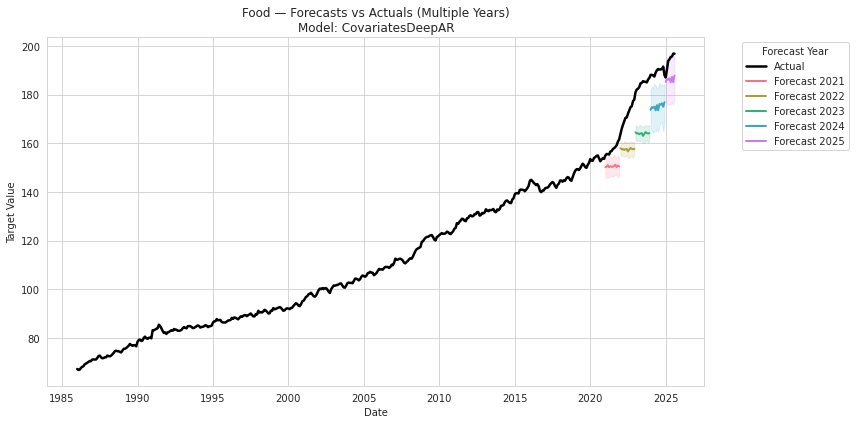

In [3]:
# ======================================================================
# 🔍 MULTI-YEAR FORECAST CHECK & VISUALIZATION (Local + Global)
# ======================================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def load_forecast(category, model_name, forecast_year, base_dir, covariates_used=True):
    """
    Loads a standardized forecast CSV for a given category/model/year.
    Automatically includes 'Covariates' prefix if present in file naming.
    """
    model_tag = f"Covariates{model_name}" if covariates_used else model_name
    file_path = os.path.join(
        base_dir,
        category.replace("/", "_"),
        str(forecast_year),
        f"{category}_{model_tag}_forecasts.csv"
    )
    if not os.path.exists(file_path):
        print(f"⚠️ Missing forecast: {file_path}")
        return None

    df = pd.read_csv(file_path, parse_dates=["timestamp"], dayfirst=False)
    df["forecast_year"] = forecast_year
    df["model"] = model_tag
    return df


def plot_multi_year_forecasts(ts_df, category, model_name, base_dir, covariates_used=True):
    """
    Plots actual data and all available forecast years for a given category & model.
    Works with both Local and Global forecasts.
    """
    model_dir = os.path.join(base_dir, category.replace("/", "_"))
    if not os.path.exists(model_dir):
        print(f"⚠️ No forecasts found for category {category}")
        return

    # Detect all available forecast years
    years = sorted([int(y) for y in os.listdir(model_dir) if y.isdigit()])
    if not years:
        print(f"⚠️ No forecast years found for {category}")
        return

    # Load forecasts for all years
    all_forecasts = []
    for year in years:
        df = load_forecast(category, model_name, year, base_dir, covariates_used)
        if df is not None:
            all_forecasts.append(df)

    if not all_forecasts:
        print(f"⚠️ No forecasts loaded for {category}")
        return

    forecasts = pd.concat(all_forecasts, ignore_index=True)
    palette = sns.color_palette("husl", len(years))

    # Retrieve actuals
    actual = ts_df.loc[category].reset_index().set_index("timestamp")["target"]

    # Plot setup
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, color="black", linewidth=2.5, label="Actual")

    for i, (year, color) in enumerate(zip(years, palette)):
        df = forecasts[forecasts["forecast_year"] == year]
        if df.empty:
            continue
        plt.plot(df["timestamp"], df["q_0.5"], label=f"Forecast {year}", color=color, linewidth=2)
        if {"q_0.25", "q_0.75"}.issubset(df.columns):
            plt.fill_between(df["timestamp"], df["q_0.25"], df["q_0.75"], color=color, alpha=0.15)

    plt.title(f"{category} — Forecasts vs Actuals (Multiple Years)\nModel: {('Covariates' if covariates_used else '')}{model_name}")
    plt.xlabel("Date")
    plt.ylabel("Target Value")
    plt.legend(title="Forecast Year", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# 🧩 Example: visualize all forecast years for one model & category
# ----------------------------------------------------------------------
base_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts"

category = "Food"  # e.g., "Vegetables and vegetable preparations"
model_name = "DeepAR"

plot_multi_year_forecasts(ts_df, category, model_name, base_dir, covariates_used=True)


In [4]:
# ======================================================================
# 🎯 FINAL GLOBAL FORECAST GENERATION (train ≤ 2025-08-01 → forecast Sep 2025–Dec 2026)
#   - Trains one global model over all categories
#   - Predicts for each (model, category)
#   - Saves to: <base>/<category>/<2026>/<category>_Covariates<Model>_forecasts.csv
# ======================================================================

import os, time
import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor

# If you didn't define time_limit earlier, default to 1800s
try:
    time_limit
except NameError:
    time_limit = 1800

final_train_cutoff = "2025-08-01"
final_forecast_horizon = 16  # (Sep 2025 – Dec 2026)
final_output_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts"
forecast_year = 2026
quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Toggle depending on whether covariates were used
COVARIATES_USED = True  # controls "Covariates" tag in filenames

os.makedirs(final_output_dir, exist_ok=True)

# -------------------------------
# Helper: CFPR-standardized save
# -------------------------------
def save_standard_forecast(pred_df, category, model_name, forecast_year, output_root, covariates_used=False):
    pred_df = pred_df.copy()
    pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"], errors="coerce")

    # Rename quantile columns if needed
    quantile_cols = {
        "0.01": "q_0.01", "0.05": "q_0.05", "0.1": "q_0.1",
        "0.25": "q_0.25", "0.5": "q_0.5", "0.75": "q_0.75",
        "0.9": "q_0.9", "0.95": "q_0.95", "0.99": "q_0.99"
    }
    pred_df = pred_df.rename(columns=quantile_cols)
    if "mean" in pred_df.columns and "q_0.5" not in pred_df.columns:
        pred_df["q_0.5"] = pred_df["mean"]

    desired_cols = ["timestamp", "q_0.5", "q_0.01", "q_0.05", "q_0.1",
                    "q_0.25", "q_0.75", "q_0.9", "q_0.95", "q_0.99"]
    for col in desired_cols:
        if col not in pred_df.columns:
            pred_df[col] = np.nan
    pred_df = pred_df[desired_cols].round(3)

    out_dir = os.path.join(output_root, category.replace("/", "_"), str(forecast_year))
    os.makedirs(out_dir, exist_ok=True)
    model_tag = f"Covariates{model_name}" if covariates_used else model_name
    out_path = os.path.join(out_dir, f"{category}_{model_tag}_forecasts.csv")
    pred_df.to_csv(out_path, index=False)
    print(f"💾 Saved → {out_path}")

# ----------------------------------------------------------------------
# 🚀 Train & Forecast
# ----------------------------------------------------------------------
print("\n" + "=" * 80)
print("🚀 GENERATING FINAL GLOBAL FORECASTS (Sep 2025 – Dec 2026)")
print("=" * 80)

cutoff_ts = pd.Timestamp(final_train_cutoff)

# 1️⃣ Global training data: ALL categories ≤ cutoff
train_data = ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff_ts]
print(f"✅ Global training rows: {len(train_data)} | series: "
      f"{train_data.num_items if hasattr(train_data,'num_items') else 'n/a'}")

# 2️⃣ Train one global predictor (shared across categories)
predictor = TimeSeriesPredictor(
    target="target",
    prediction_length=final_forecast_horizon,
    freq="MS",
    path=os.path.join(final_output_dir, "Global_Model"),
    eval_metric="MAPE",
    quantile_levels=quantiles,
)

t0 = time.time()
predictor.fit(
    train_data=train_data,
    presets="medium_quality",
    time_limit=time_limit,
    hyperparameters={m: {} for m in model_list},
)
print(f"✅ Finished global training in {time.time() - t0:.1f}s")

trained_models = model_list
print(f"🧩 Trained models: {trained_models}")

# 3️⃣ Predict per (category, model) → clip to Sep 2025–Dec 2026 → save
for category in food_categories:
    print("\n" + "-" * 70)
    print(f"📊 Generating forecasts for: {category}")
    print("-" * 70)

    # Subset training data for this category only
    cat_train = train_data.loc[train_data.index.get_level_values("item_id") == category]
    if len(cat_train) == 0:
        print(f"⚠️ No training data for category '{category}' before {final_train_cutoff} — skipping.")
        continue

    for model_name in trained_models:
        print(f"   ➤ Predicting with model: {model_name}")
        try:
            preds = predictor.predict(cat_train, model=model_name)
        except Exception as e:
            print(f"❌ Could not generate forecast for {category} ({model_name}): {e}")
            continue

        pred_df = preds.reset_index()
        pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"], errors="coerce")
        pred_df["timestamp"] = pred_df["timestamp"].dt.to_period("M").apply(lambda p: p.start_time)

        # ✅ Keep Sep 2025 → Dec 2026
        pred_df_ext = pred_df[
            (pred_df["timestamp"] >= pd.Timestamp("2025-09-01")) &
            (pred_df["timestamp"] <= pd.Timestamp("2026-12-01"))
        ].copy()

        if pred_df_ext.empty:
            print(f"⚠️ No Sep 2025–Dec 2026 horizon produced for {category} ({model_name}). Skipping save.")
            continue

        # ✅ Save the filtered forecast in standardized format
        save_standard_forecast(
            pred_df=pred_df_ext,
            category=category,
            model_name=model_name,
            forecast_year=forecast_year,        # save under 2026 folder
            output_root=final_output_dir,
            covariates_used=COVARIATES_USED     # adds 'Covariates' tag
        )

print("\n✅ ALL FINAL GLOBAL FORECASTS GENERATED SUCCESSFULLY!")
print(f"📁 Saved in: {final_output_dir}")


Beginning AutoGluon training... Time limit = 6s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Global_Model'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       113.61 GB / 125.17 GB (90.8%)
Disk Space Avail:   25313.87 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {}, 'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target


🚀 GENERATING FINAL GLOBAL FORECASTS (Sep 2025 – Dec 2026)
✅ Global training rows: 4284 | series: 9


	-0.0528       = Validation score (-MAPE)
	2.17    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 1.9s of the 3.7s of remaining time.
	-0.0486       = Validation score (-MAPE)
	1.86    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 1.0}
	-0.0486       = Validation score (-MAPE)
	0.32    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer', 'DeepAR', 'WeightedEnsemble']
Total runtime: 4.58 s
Best model: DeepAR
Best model score: -0.0486


✅ Finished global training in 4.7s
🧩 Trained models: ['DeepAR', 'TemporalFusionTransformer']

----------------------------------------------------------------------
📊 Generating forecasts for: Bakery and cereal products (excluding baby food)
----------------------------------------------------------------------
   ➤ Predicting with model: DeepAR
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and cereal products (excluding baby food)_CovariatesDeepAR_forecasts.csv
   ➤ Predicting with model: TemporalFusionTransformer
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/Bakery and cereal products (excluding baby food)/2026/Bakery and cereal products (excluding baby food)_CovariatesTemporalFusionTransformer_forecasts.csv

----------------------------------------------------------------------
📊 Generating forecasts for: Dairy products and eggs
-----------------------------


📈 Plotting category: Bakery and cereal products (excluding baby food)
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Bakery and cereal products (excluding baby food)_GlobalForecasts_Sep2025.png


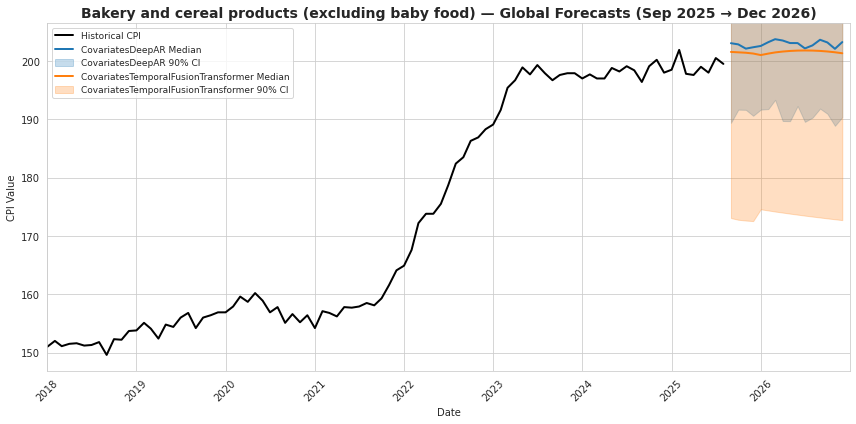


📈 Plotting category: Dairy products and eggs
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Dairy products and eggs_GlobalForecasts_Sep2025.png


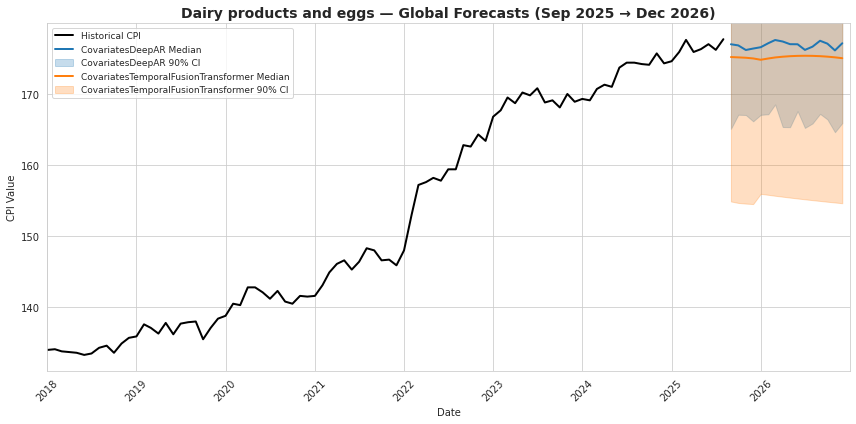


📈 Plotting category: Fish, seafood and other marine products
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Fish, seafood and other marine products_GlobalForecasts_Sep2025.png


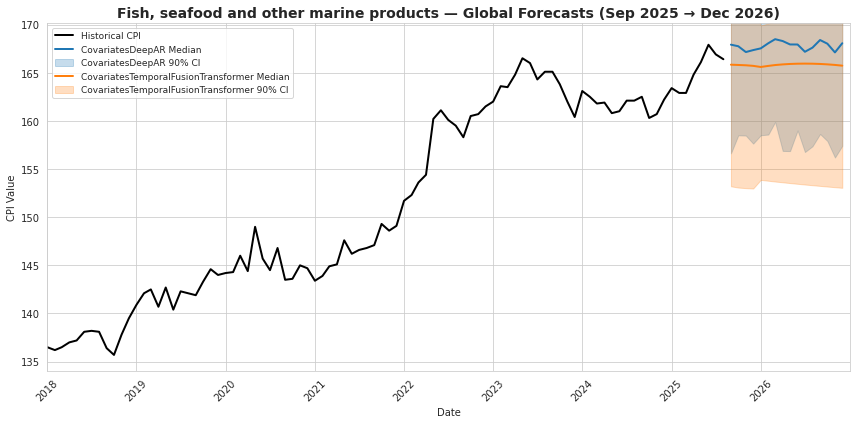


📈 Plotting category: Food purchased from restaurants
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Food purchased from restaurants_GlobalForecasts_Sep2025.png


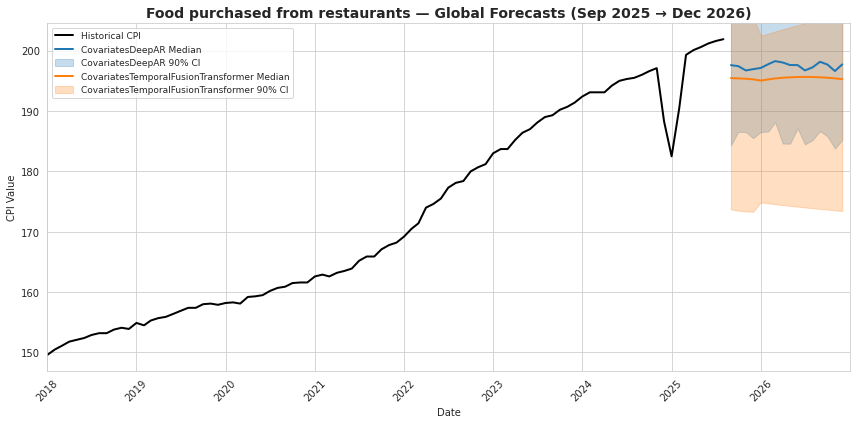


📈 Plotting category: Food
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Food_GlobalForecasts_Sep2025.png


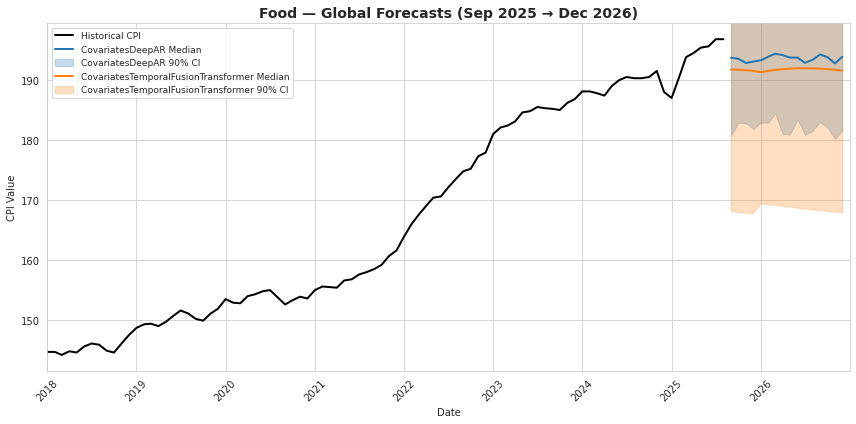


📈 Plotting category: Fruit, fruit preparations and nuts
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Fruit, fruit preparations and nuts_GlobalForecasts_Sep2025.png


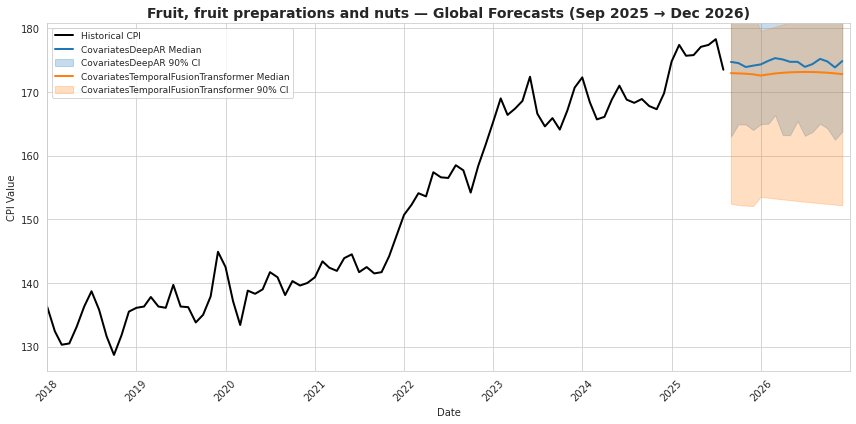


📈 Plotting category: Meat
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Meat_GlobalForecasts_Sep2025.png


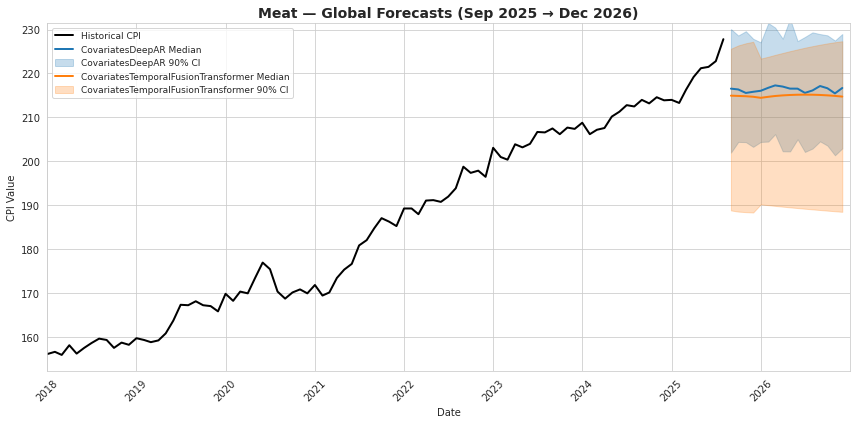


📈 Plotting category: Other food products and non-alcoholic beverages
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Other food products and non-alcoholic beverages_GlobalForecasts_Sep2025.png


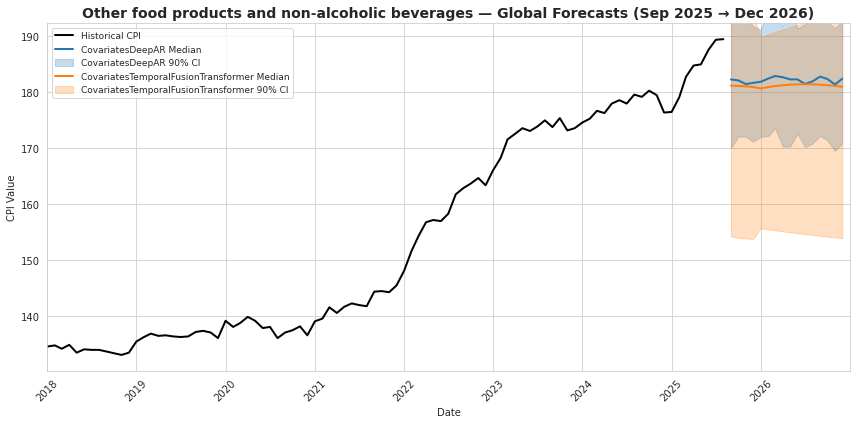


📈 Plotting category: Vegetables and vegetable preparations
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Vegetables and vegetable preparations_GlobalForecasts_Sep2025.png


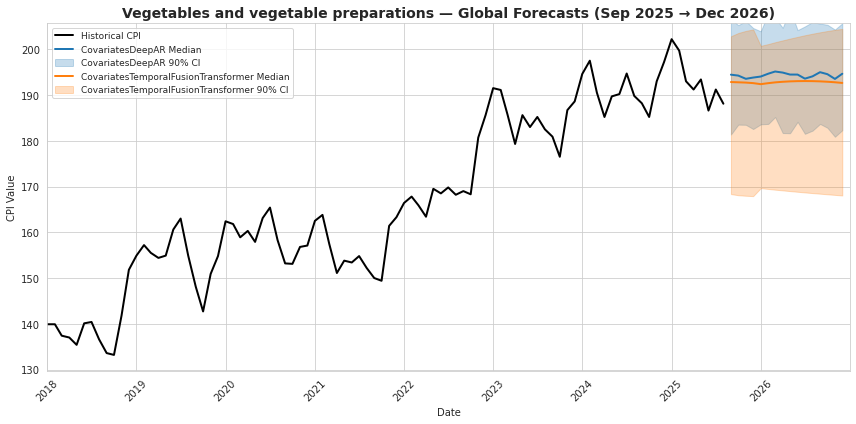


✅ Done plotting all categories (Global forecasts with Sep 2025 start).


In [5]:
# ======================================================================
# 📊 VISUALIZE FINAL GLOBAL FORECASTS (Sep 2025 → Dec 2026)
# ======================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


def plot_all_final_forecasts_exact(
    ts_df,
    food_categories,
    model_list,
    base_dir,
    show_plots=True,
    save_plots=True,
    start_year=2018,
    forecast_year="2026",
    covariates_used=True
):
    """
    Plot all final forecasts for all categories and models, showing the forecast period
    from Sep 2025 → Dec 2026 (instead of starting at Jan 2026).

    Parameters
    ----------
    ts_df : TimeSeriesDataFrame
        MultiIndex (item_id, timestamp) of actual values.
    food_categories : list
        Category names (exact match with item_id).
    model_list : list
        Model names (e.g., ["DeepAR", "TemporalFusionTransformer"]).
    base_dir : str
        Directory containing saved forecast CSVs.
    """
    sns.set_style("whitegrid")

    plot_dir = os.path.join(base_dir, "plots_exact")
    os.makedirs(plot_dir, exist_ok=True)

    forecast_start = pd.Timestamp("2025-09-01")
    forecast_end = pd.Timestamp("2026-12-31")

    for category in food_categories:
        print(f"\n📈 Plotting category: {category}")

        # ------------------------------------------------------------------
        # Load actual data
        # ------------------------------------------------------------------
        if category not in ts_df.index.get_level_values("item_id"):
            print(f"❌ '{category}' not found in ts_df item_id index — skipping.")
            continue

        series = ts_df.loc[category]
        if isinstance(series, pd.DataFrame) and "target" in series.columns:
            series = series["target"]
        series.index = pd.to_datetime(series.index)
        series = series.sort_index()

        context_df = series[series.index <= "2025-10-01"]
        actual_df = series[(series.index > "2025-09-01") & (series.index <= forecast_end)]
        context_df = context_df[context_df.index >= pd.Timestamp(f"{start_year}-01-01")]

        # ------------------------------------------------------------------
        # Load forecasts
        # ------------------------------------------------------------------
        category_clean = category.replace("/", "_")
        forecast_dir = os.path.join(base_dir, category_clean, str(forecast_year))

        forecast_dict = {}
        for model_name in model_list:
            model_tag = f"Covariates{model_name}" if covariates_used else model_name
            forecast_path = os.path.join(forecast_dir, f"{category}_{model_tag}_forecasts.csv")
            if not os.path.exists(forecast_path):
                print(f"⚠️ Missing forecast for {category} ({model_tag}) → {forecast_path}")
                continue

            forecast_df = pd.read_csv(forecast_path)
            forecast_df["timestamp"] = pd.to_datetime(forecast_df["timestamp"], errors="coerce")
            forecast_df = forecast_df.dropna(subset=["timestamp"]).set_index("timestamp").sort_index()

            # 👇 Extend forecast display window back to Sep 2025
            forecast_df = forecast_df[
                (forecast_df.index >= forecast_start) & (forecast_df.index <= forecast_end)
            ]
            forecast_dict[model_tag] = forecast_df

        if not forecast_dict:
            print(f"⚠️ No forecast files found for {category}, skipping.")
            continue

        # ------------------------------------------------------------------
        # Plot setup
        # ------------------------------------------------------------------
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(context_df.index, context_df.values, color="black", linewidth=2, label="Historical CPI")

        if len(actual_df) > 0:
            ax.plot(actual_df.index, actual_df.values, color="gray", linewidth=2, linestyle="--", label="Observed (Actual)")

        palette = sns.color_palette("tab10", n_colors=len(forecast_dict))

        for i, (model_tag, fdf) in enumerate(forecast_dict.items()):
            if "q_0.5" not in fdf.columns:
                if "mean" in fdf.columns:
                    fdf["q_0.5"] = fdf["mean"]
                else:
                    print(f"⚠️ Skipping {model_tag}: no median/mean column.")
                    continue

            ax.plot(
                fdf.index,
                fdf["q_0.5"],
                color=palette[i],
                linewidth=2,
                label=f"{model_tag} Median",
            )

            if {"q_0.05", "q_0.95"}.issubset(fdf.columns):
                ax.fill_between(
                    fdf.index,
                    fdf["q_0.05"],
                    fdf["q_0.95"],
                    color=palette[i],
                    alpha=0.25,
                    label=f"{model_tag} 90% CI",
                )

        ax.set_title(f"{category} — Global Forecasts (Sep 2025 → Dec 2026)", fontsize=14, fontweight="bold")
        ax.set_xlabel("Date")
        ax.set_ylabel("CPI Value")
        ax.legend(loc="upper left", fontsize=9)
        ax.set_xlim(pd.Timestamp(f"{start_year}-01-01"), forecast_end)
        plt.xticks(rotation=45)

        # Y-axis range with margin
        y_min = min(context_df.min(), *(fdf["q_0.5"].min() for fdf in forecast_dict.values() if "q_0.5" in fdf))
        y_max = max(context_df.max(), *(fdf["q_0.5"].max() for fdf in forecast_dict.values() if "q_0.5" in fdf))
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

        plt.tight_layout()

        save_path = os.path.join(plot_dir, f"{category_clean}_GlobalForecasts_Sep2025.png")
        if save_plots:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"💾 Saved → {save_path}")
        if show_plots:
            plt.show()
        else:
            plt.close()

    print("\n✅ Done plotting all categories (Global forecasts with Sep 2025 start).")


# ----------------------------------------------------------------------
# 🧩 Example call
# ----------------------------------------------------------------------
final_output_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts"

plot_all_final_forecasts_exact(
    ts_df=ts_df,
    food_categories=food_categories,
    model_list=model_list,
    base_dir=final_output_dir,
    show_plots=True,
    save_plots=True,
    start_year=2018,
    forecast_year="2026",
    covariates_used=True
)
